# Project 2: Take Home test (Konigle - NLP Project)

Hi there! We are very very happy to have you interview with us! <br>

The idea behind this challenge, is to see how you think, prioritize tasks and work with real problem.
There is **no right or wrong answer**; we just want to get a feel of what you can do.
Don't be afraid to ask questions!

**Questions are there to guide you; but feel free to play with the dataset and go further than what is written in the guidelines!**





# Project Description

<br>

**Project Objective:** The objective is to perform binary classification on the tweets from airline passengers in US for six different airlines. The classes are
1. **Negative**
2. **Non-Negative**

Originaly, the dataset contains three different classes, **you may have to merge the positive and negative class in a single class**.

**Dataset**: The download link has been provided below.

This data set contains roughly 15K tweets with 3 possible classes for the sentiment (positive, negative and neutral). The data has been already cleaned from the original format, but you can further clean the data if it can increases the accuracy of the model. 

Here, you are advised to start with basic model and then use any pre-trained word embedding method such as word2vec, GloVe, FastText to compare the results.



In [ ]:
# You can download the dataset using (please uncomment to download)
!wget "https://www.dropbox.com/s/fz6fup7d2yrowoj/Tweets.csv"
!ls -la

In [38]:
import pandas as pd

# from google.colab import files
# import io

# uploaded = files.upload()
df = pd.read_csv("Tweets.csv", header=0, encoding = "ISO-8859-1")

# df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24/2/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24/2/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24/2/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24/2/2015 11:14,NaN,Pacific Time (US & Canada)


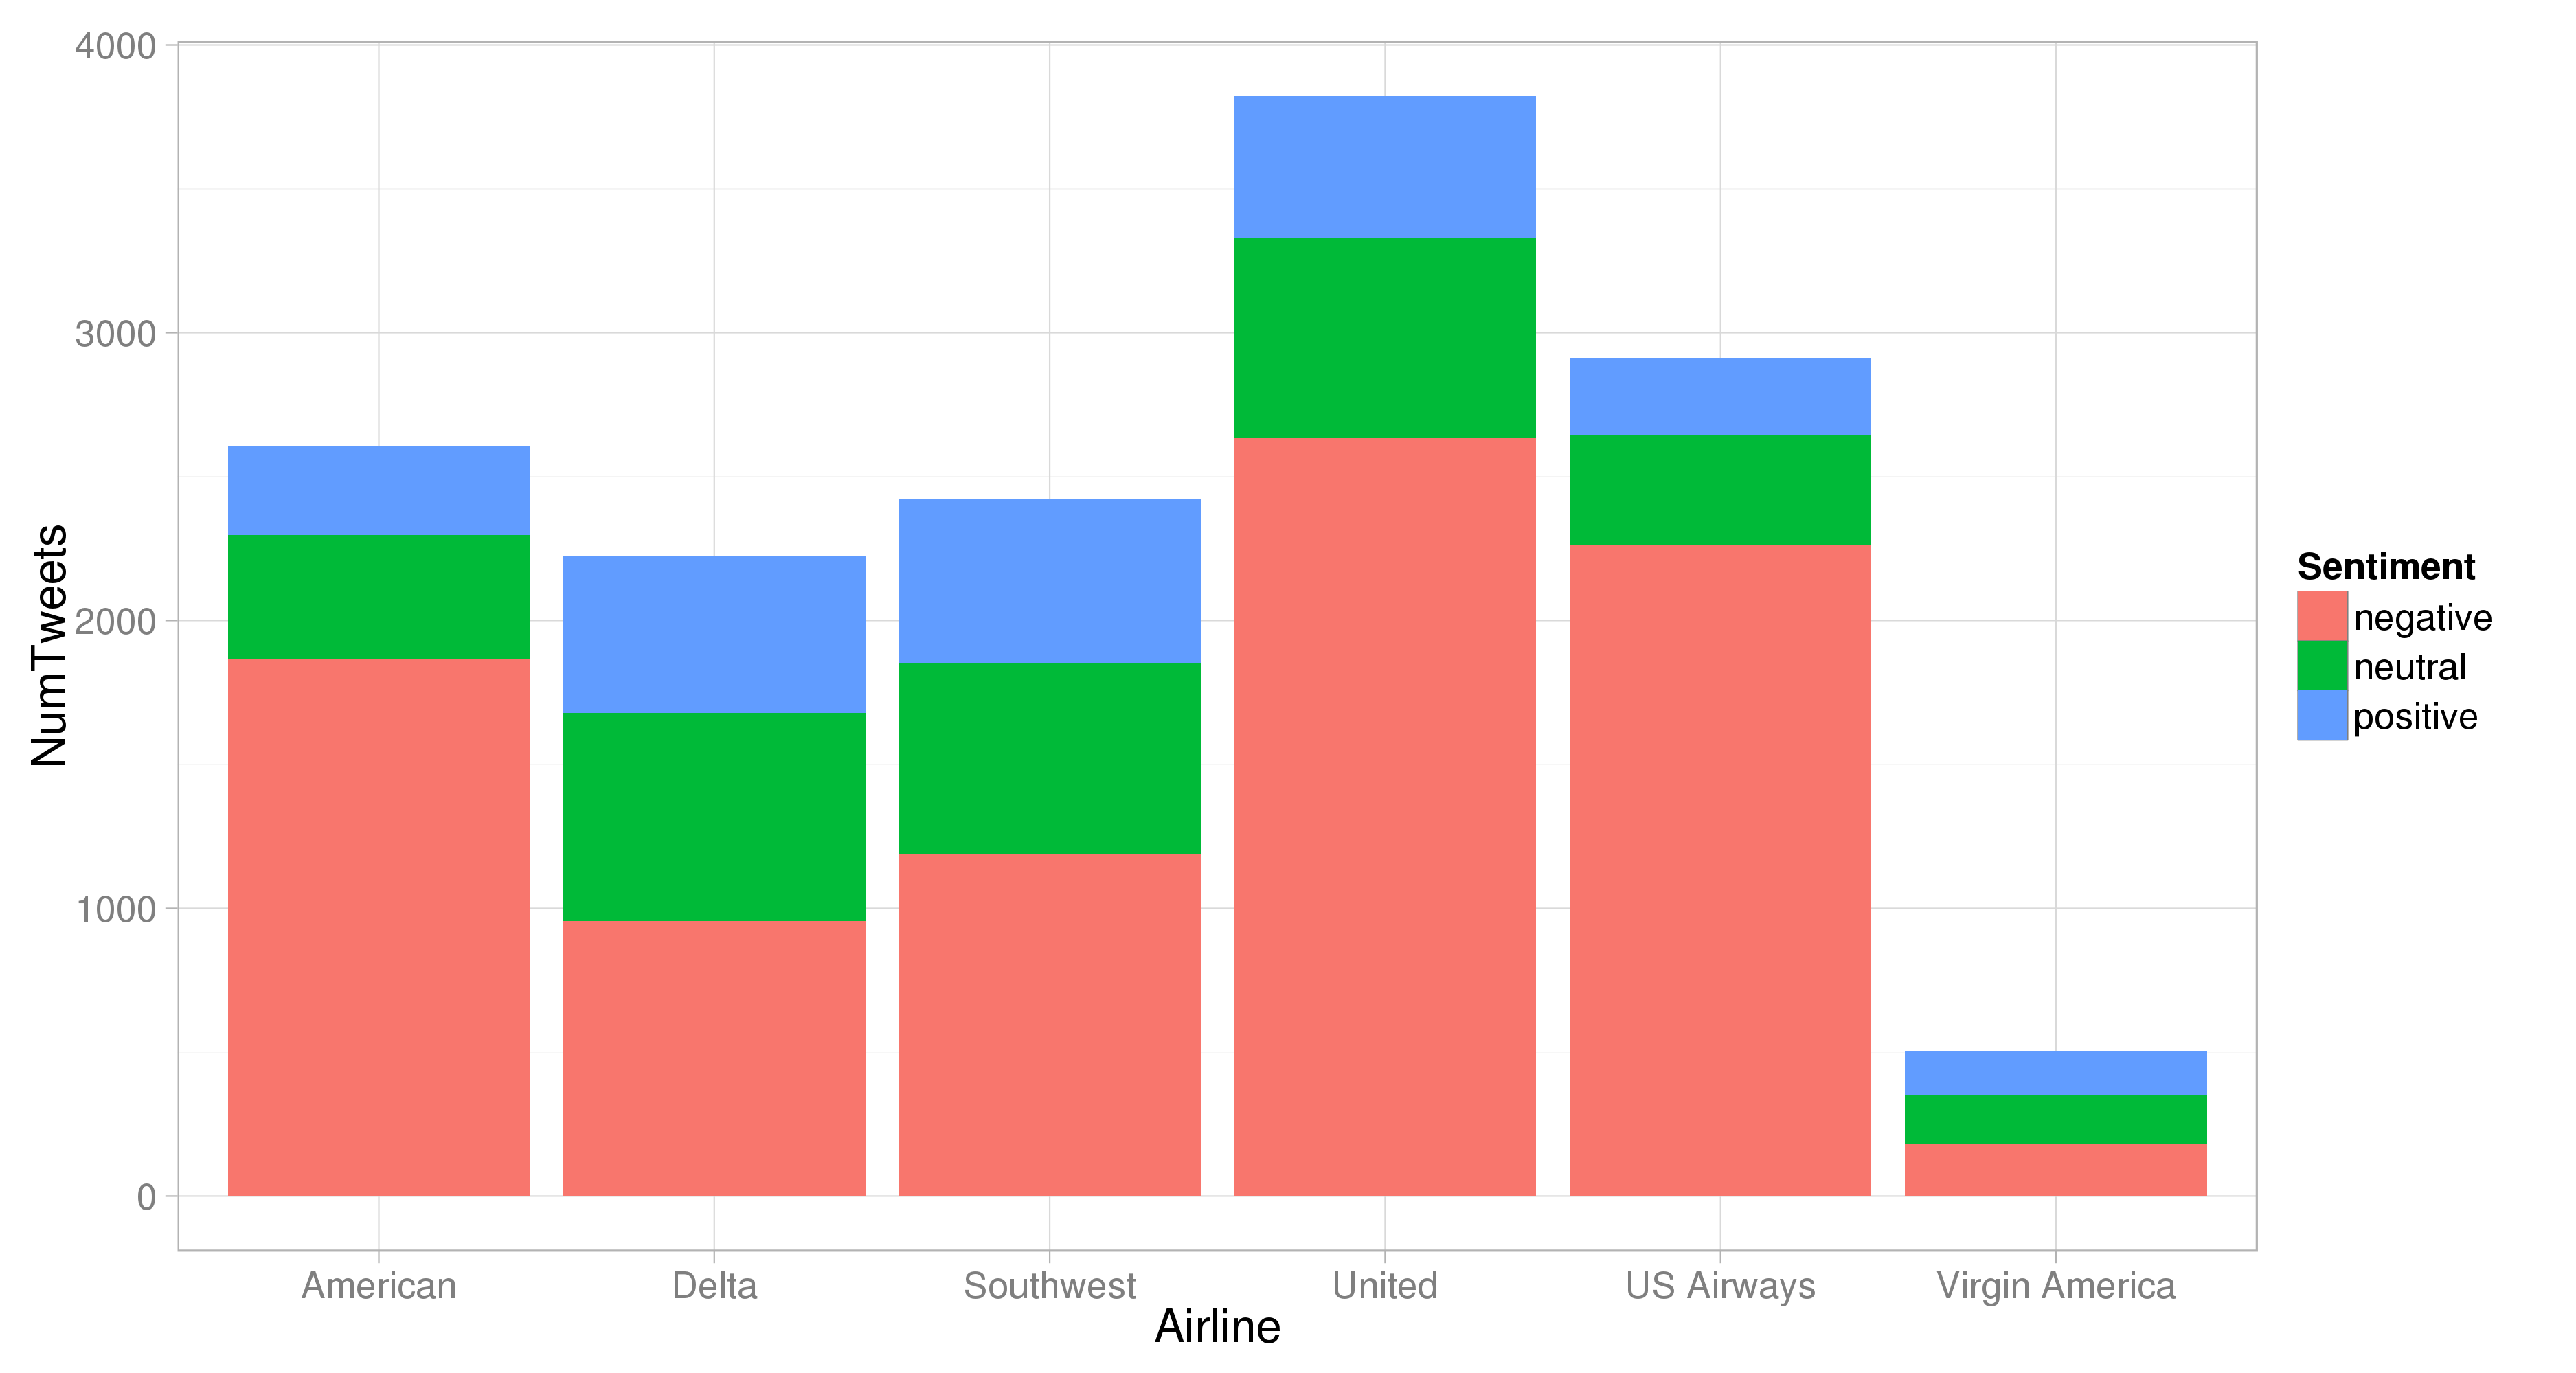

# Project Preperation

## Setup projet

In [75]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# static variables
TRAIN_TEST_SPLIT = 0.9
TRAIN_VAL_SPLIT = 0.8
RANDOM_STATE = 1234
EMBEDDING_DIM = 100

In [53]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.regularizers import l1, l2, l1_l2

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

import spacy

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, KeyedVectors

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')
# !python -m spacy download en
nlp = spacy.load('en')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Utility Functions

In [41]:
def oversample(df, label_column):
    """
    Oversampling on data
    --------------------------------------
    Args:
        df: training dataframe
        label_column: name of the output column
    Returns:
        return the new oversampled dataframe
    """
    # Assume the label is either 0 or 1.
    df_class_0 = df[df[label_column] == 0]
    df_class_1 = df[df[label_column] == 1]

    count_class_0 = len(df_class_0)
    count_class_1 = len(df_class_1)

    # Address unblanced data issue: Oversampling on data samples with rare outputs
    if count_class_0 > count_class_1: 
        df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=RANDOM_STATE)
        new_df = pd.concat([df_class_1_over, df_class_0], axis=0)
    elif count_class_0 < count_class_1:
        df_class_0_over = df_class_0.sample(count_class_1, replace=True, random_state=RANDOM_STATE)
        new_df = pd.concat([df_class_0_over, df_class_1], axis=0)
    else: 
        new_df = df
    return new_df.reset_index(drop=True)

In [42]:
def plot_history(history): 
    """
    Plot the training/validaiton accuraccy as well as training/validaiton loss .
    --------------------------------------
    Args:
        history: training history returned by model.fit()
    Returns:
        NUll
    """
    # the keyname on google colab is acc while on my laptop is accuracy :(
    if 'acc' in history.history:  
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    elif 'accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        
    # summarize history for acc
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [43]:
def auc_roc_curve(y, pred, model_name):
    """
    Plot the ROC AUC curve of classification model .
    --------------------------------------
    Args:
        y: ground truth
        pred: predicted label
        model_name: name of the model
    Returns:
        NUll
    """
    
    # no skill prediction
    ns_pred = [0 for _ in range(len(y))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_pred)
    lr_fpr, lr_tpr, _ = roc_curve(y, pred)
    # plot the roc curve for the model
    plt.title("{} ROC AUC curve".format(model_name))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    # summarize scores
    lr_auc = roc_auc_score(y, pred)
    print('AUC score = %.3f' % (lr_auc))

In [76]:
def show_confusion_matrix(truth, pred):
    """
    plot confusion matrix.
    --------------------------------------
    Args:
        truth: ground truth
        pred: predicted label
    Returns:
        NUll
    """
    
    # convert the predicted value to binary in case it is not. 
    pred_binary = list(map(lambda x: 1 if x >= 0.5 else 0, pred))
    
    cm = confusion_matrix(y_test, pred_binary)
    
    class_name = ['negative', 'non-negative']
    df_cm = pd.DataFrame(cm, columns=class_name)
    df_cm = df_cm.set_index(pd.Series(class_name))
    print(cm)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    tp_rate = cm[0][0]/(cm[0][0] + cm[1][0])
    precision = cm[0][0]/sum(cm[0])
    
    class_names = ['negative', 'non-negative']
    
    sns.heatmap(df_cm, annot=True, xticklabels=True, yticklabels="auto",
            fmt='4', cmap='Blues')
    
    print("Accuracy: {}".format(accuracy))
    print("True Positive Rate: {}".format(tp_rate))
    print("precision: {}".format(precision))
    

## Clean and augment data

Look at the histogram of the three classes

(array([3099.,    0.,    0.,    0.,    0., 2363.,    0.,    0.,    0.,
        9178.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

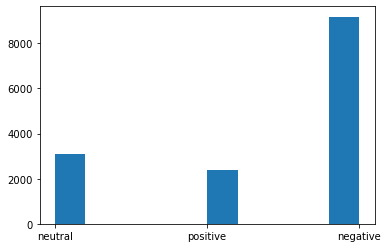

In [45]:
plt.hist(df['airline_sentiment'])

The histogram shows the data set is kind of unbalanced in terms the three classes. Since the scope is to classify negative and non-negative, class "positive" and "neutral" can be merged into one class, "non-negative". 

(array([5462.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        9178.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

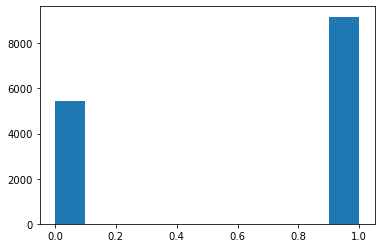

In [46]:
df['is_negative_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x == "negative" else 0)
plt.hist(df["is_negative_sentiment"])

There are less than 6k non-negative tweets and more than 8k negative tweets. Although the number of the two classes are not very far away, it could still lead to potential problems in the model's performance. Thus, oversampling is adopted to balance the data set. 

(array([9178.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        9178.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

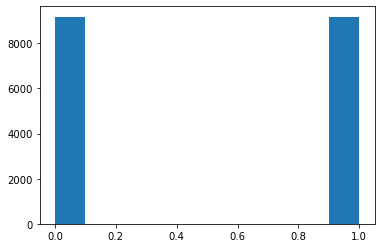

In [47]:
balanced_df = oversample(df, "is_negative_sentiment")
plt.hist(balanced_df["is_negative_sentiment"])

Now the data set is balanced. For the next step, I split the data into train, validation, and test set.

In [48]:
# train: test = 9: 1
train_data = balanced_df.sample(int(TRAIN_TEST_SPLIT*len(balanced_df)), random_state=RANDOM_STATE)
test_data = balanced_df[~balanced_df.index.isin(train_data.index)]

# real train: val = 8: 2
train_train_data = train_data.sample(int(TRAIN_VAL_SPLIT*len(train_data)), random_state=RANDOM_STATE)
val_data = train_data[~train_data.index.isin(train_train_data.index)]

X_train = train_train_data['text'].values
y_train = train_train_data['is_negative_sentiment'].values

X_val = val_data['text'].values
y_val = val_data['is_negative_sentiment'].values

X_test = test_data['text'].values
y_test = test_data['is_negative_sentiment'].values

Not all the words are useful in the sentimental classification. For instance, stop words like 'a', 'I', 'the', punctuations, and other tokens can be removed from the data set. However, there are a lot of emocticons in the tweets (shown in data exploration.) and they are useful in classifying the sentiments. Thus, these emojis should be kept. 

In [60]:
# function to preprocess the tweets.
def preprocess(texts, allowed_postags=['NOUN', "ADJ", "VERB", "ADV", "PROPN", "DET"]): 
    texts_out = []
    for text in texts: 
        # lower case the sentences
        lowered_text = text.lower()
    
        # parse the text with nlp() from spacy. It treats emoticons as words.
        doc = nlp(lowered_text)

        # remove space, numericals, and punctuation.
        tokens = [token for token in doc if not (token.is_punct | 
                                               token.is_space |  
                                               token.is_digit)]

        # lemmatization, filter words by pos tag.
        lemmas = [token.lemma_ for token in tokens if token.pos_ in allowed_postags]
      
        # remove stop words
        words = [lemma for lemma in lemmas if lemma not in stop_words]

        texts_out.append(words)
    return texts_out

In [50]:
# it might take a few minutes to preprocess the data.

train_corpus = preprocess(X_train)
val_corpus = preprocess(X_val)
test_corpus = preprocess(X_test)

In [51]:
corpus = train_corpus + val_corpus + test_corpus

After pre-process the data, convert the data into vector of integers with each word represented by its index. The sequences are padded such that every sequence has the same length.

In [61]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

train_sequences = tokenizer.texts_to_sequences(train_corpus)
val_sequences = tokenizer.texts_to_sequences(val_corpus)
test_sequences = tokenizer.texts_to_sequences(test_corpus)

# the dictionary of word occurrences.
word_index = tokenizer.word_index

train_max_length = max([len(x) for x in train_sequences])
val_max_length = max([len(x) for x in val_sequences])
test_max_length = max([len(x) for x in test_sequences])

max_length = max(train_max_length, val_max_length, test_max_length)

X_train_pad = pad_sequences(train_sequences, maxlen=max_length, padding="post")
X_val_pad = pad_sequences(val_sequences, maxlen=max_length, padding="post")
X_test_pad = pad_sequences(test_sequences, maxlen=max_length, padding="post")

vocab = np.array(list(tokenizer.word_index.keys()))
vocab_size = len(tokenizer.word_index) + 1

## Data Exploration 

In [0]:
# the emoji can also be captured. 
tokenizer.texts_to_sequences(["I ❤️ flying @VirginAmerica. ☺️👍 "])

[[1182, 1851]]

In [0]:
df['text'].tolist()[18]

I ❤️ flying @VirginAmerica. ☺️👍 


# Modelling

## Build the base model

### 1. Deep nerual network model

The base model firstly converts train embeddings for each words in a sentence, which is done by a keras embedding layer. The semantic information is then passed to a deep recurrent network where GRU is employed to capture long term dependencies in the sentences. The information is then compressed to a single value representing the predicted class of a sentence. 

In [70]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_val_pad, y_val), verbose=2)

D:\Anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13216 samples, validate on 3304 samples
Epoch 1/25
 - 27s - loss: 0.4818 - accuracy: 0.7542 - val_loss: 0.5533 - val_accuracy: 0.8317
Epoch 2/25
 - 29s - loss: 0.2945 - accuracy: 0.8809 - val_loss: 0.5485 - val_accuracy: 0.8196
Epoch 3/25
 - 27s - loss: 0.2269 - accuracy: 0.9155 - val_loss: 0.5317 - val_accuracy: 0.8248
Epoch 4/25
 - 25s - loss: 0.1851 - accuracy: 0.9331 - val_loss: 0.5109 - val_accuracy: 0.7848
Epoch 5/25
 - 25s - loss: 0.1598 - accuracy: 0.9417 - val_loss: 0.4307 - val_accuracy: 0.8402
Epoch 6/25
 - 24s - loss: 0.1459 - accuracy: 0.9492 - val_loss: 0.4679 - val_accuracy: 0.8181
Epoch 7/25
 - 24s - loss: 0.1311 - accuracy: 0.9542 - val_loss: 0.4870 - val_accuracy: 0.8432
Epoch 8/25
 - 24s - loss: 0.1250 - accuracy: 0.9563 - val_loss: 0.4387 - val_accuracy: 0.8266
Epoch 9/25
 - 24s - loss: 0.1138 - accuracy: 0.9610 - val_loss: 0.4609 - val_accuracy: 0.8226
Epoch 10/25
 - 24s - loss: 0.1030 - accuracy: 0.9646 - val_loss: 0.4304 - val_accuracy: 0.8426
Epoch 11/2

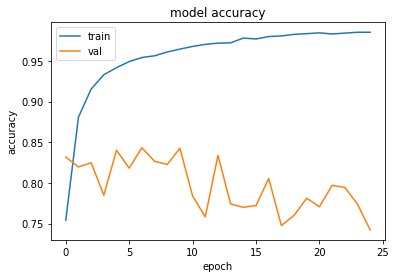

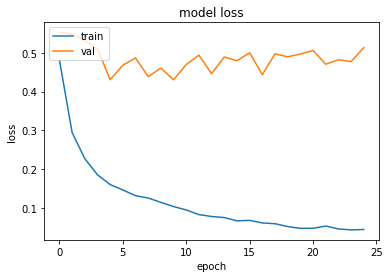

In [72]:
plot_history(history)

The validation accuracy and loss don't really follow the same trend with the training set. That implies the model might be overfitting towards the training data.

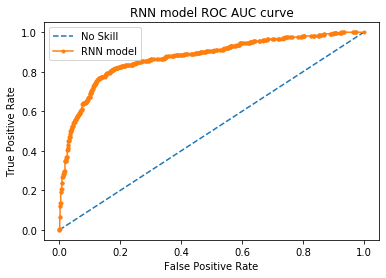

AUC score = 0.872


In [73]:
test_pred = model.predict(X_test_pad)
auc_roc_curve(y_test, test_pred, "RNN model")

[[877  56]
 [381 522]]
Accuracy: 0.7619825708061002
True Positive Rate: 0.6971383147853736
precision: 0.939978563772776


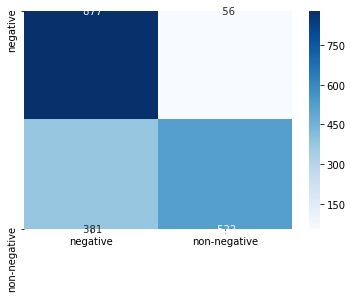

In [74]:
show_confusion_matrix(y_test, test_pred)

The Auc score is ok but the model's recall is very low. The naive model is not very effective in detecing negative tweets. 

### 2. Naive bayes

Naive bayes is also an effective way to do sentiment classification. However, building a complete feature matrix for over 10k training data is relatively expensive. Thus, it is not very partical due to the time constraints. Possible solutions could be identify the most important words from the corpus and build feature matrix only on those words.

Assumptions: features are independent.

In [0]:
print(vocab_size)

11216


In [0]:
def build_features(documents, labels):
    # zip the text and labels
    documents = np.column_stack((documents, labels))
    
    all_features = []
    for doc in documents: 
        features = {}
        words_in_doc = set(doc[0])
        for token in vocab[:4000]: 
            features['contains {}'.format(token)] = (token in words_in_doc)
        all_features.append((features, doc[1]))
    return all_features

In [0]:
# might need extra memory. I ran this on google colab
# ToDo: reduce the number of features
all_features = build_features(X_train, y_train)

In [0]:
classifier = nltk.NaiveBayesClassifier.train(all_features)

In [0]:
test_features = build_features(X_test, y_test)

In [0]:
print(nltk.classify.accuracy(classifier, test_features))

0.6994535519125683


## Parameter tuning (if required)

In [0]:
def compile_rnn(n_layer, layer_type, n_units, v_dropout, v_rdropout, kernel_reg, rec_reg): 
    """
    Compiles a rnn based on given hyper-parameters.
    n_units, v_dropout, v_rdropout, kernel_reg, rec_reg should be in list type. Their length should be 
    equal to n_layer.
    --------------------------------------
    Args:
        n_layer: # of layers.
        layer_type: GRU, LSTM, or other.
        n_units: list. number of units in each layer. 
    Returns:
        compiled keras sequential model.
    """
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
    for i in range(n_layer):
    if i == n_layer-1: 
        model.add(layer_type(units=n_units[i], 
                          dropout=v_dropout[i], 
                          recurrent_dropout=v_rdropout[i],
                          kernel_regularizer=kernel_reg[i], 
                          recurrent_regularizer=rec_reg[i]))
    else: 
        model.add(layer_type(units=n_units[i], 
                           dropout=v_dropout[i], 
                           recurrent_dropout=v_rdropout[i],
                           return_sequences=True,
                           kernel_regularizer=kernel_reg[i], 
                           recurrent_regularizer=rec_reg[i]))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Deep RNN Model

#### 1. Regularisation

As in shown in the base model, the validation loss doesn't drop with the training loss. It could be due to overfitting. Thus, different regularization is tested on the model to restrict the weights.

As the tuning process is very time consuming, I used 60% of the original training data for a faster speed.

In [0]:
X_train_pad_shrinked = X_train_pad[:int(0.6*len(X_train_pad))]
y_train_shrinked = y_train[:int(0.6*len(y_train))]

In [0]:
# function to test different regularizers.
def run_regs():
    n_layer = 3
    layer_type = GRU
    n_units = [100]*3 
    v_dropout = [0.02]*3
    v_rdropout = [0.02]*3
    regularizers = [l1_l2(0.001, 0.001), l1_l2(0., 0.001), l1_l2(0.001, 0.), l1_l2(0., 0.)]
    for reg in regularizers:
        kernel_reg = [l1_l2(0., 0.)]*3
        rec_reg = [l1_l2(0., 0.)]*3
        model = compile_rnn(n_layer, layer_type, n_units, v_dropout, v_rdropout, kernel_reg, rec_reg)
        hist = model.fit(X_train_pad_shrinked, y_train_shrinked, batch_size=128, epochs=25, validation_data=(X_val_pad, y_val), verbose=2)
        plot_history(hist)

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 16s - loss: 0.5702 - acc: 0.6718 - val_loss: 0.4004 - val_acc: 0.8293
Epoch 2/25
 - 11s - loss: 0.3273 - acc: 0.8720 - val_loss: 0.3665 - val_acc: 0.8556
Epoch 3/25
 - 11s - loss: 0.2117 - acc: 0.9224 - val_loss: 0.4226 - val_acc: 0.8465
Epoch 4/25
 - 11s - loss: 0.1634 - acc: 0.9382 - val_loss: 0.3976 - val_acc: 0.8447
Epoch 5/25
 - 11s - loss: 0.1362 - acc: 0.9538 - val_loss: 0.4101 - val_acc: 0.8465
Epoch 6/25
 - 11s - loss: 0.1155 - acc: 0.9601 - val_loss: 0.5086 - val_acc: 0.8363
Epoch 7/25
 - 11s - loss: 0.1014 - acc: 0.9663 - val_loss: 0.5195 - val_acc: 0.8360
Epoch 8/25
 - 11s - loss: 0.0924 - acc: 0.9709 - val_loss: 0.4499 - val_acc: 0.8266
Epoch 9/25
 - 12s - loss: 0.0942 - acc: 0.9685 - val_loss: 0.5576 - val_acc: 0.8347
Epoch 10/25
 - 12s - loss: 0.0779 - acc: 0.9754 - val_loss: 0.6168 - val_acc: 0.8317
Epoch 11/25
 - 11s - loss: 0.0720 - acc: 0.9777 - val_loss: 0.8048 - val_acc: 0.8245
Epoch 12/25
 - 11s - loss:

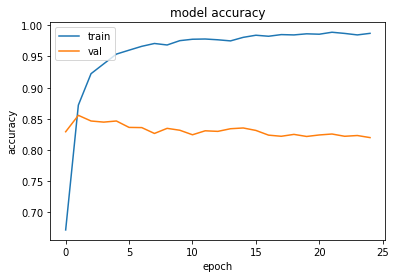

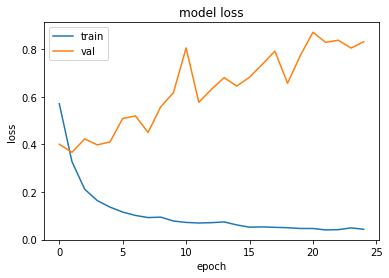

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 17s - loss: 0.6171 - acc: 0.6158 - val_loss: 0.4247 - val_acc: 0.8160
Epoch 2/25
 - 11s - loss: 0.3379 - acc: 0.8601 - val_loss: 0.3655 - val_acc: 0.8475
Epoch 3/25
 - 11s - loss: 0.2261 - acc: 0.9164 - val_loss: 0.3791 - val_acc: 0.8490
Epoch 4/25
 - 11s - loss: 0.1680 - acc: 0.9421 - val_loss: 0.4308 - val_acc: 0.8472
Epoch 5/25
 - 11s - loss: 0.1413 - acc: 0.9538 - val_loss: 0.4319 - val_acc: 0.8399
Epoch 6/25
 - 11s - loss: 0.1204 - acc: 0.9609 - val_loss: 0.4819 - val_acc: 0.8411
Epoch 7/25
 - 11s - loss: 0.1011 - acc: 0.9658 - val_loss: 0.4507 - val_acc: 0.8341
Epoch 8/25
 - 11s - loss: 0.0959 - acc: 0.9695 - val_loss: 0.4740 - val_acc: 0.8381
Epoch 9/25
 - 11s - loss: 0.0906 - acc: 0.9717 - val_loss: 0.6270 - val_acc: 0.8323
Epoch 10/25
 - 11s - loss: 0.0752 - acc: 0.9774 - val_loss: 0.5891 - val_acc: 0.8314
Epoch 11/25
 - 12s - loss: 0.0760 - acc: 0.9747 - val_loss: 0.6543 - val_acc: 0.8290
Epoch 12/25
 - 11s - loss:

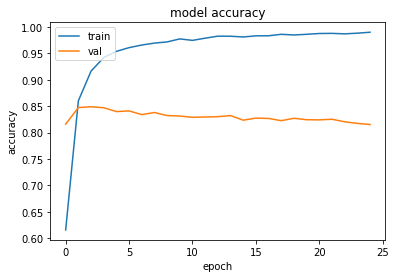

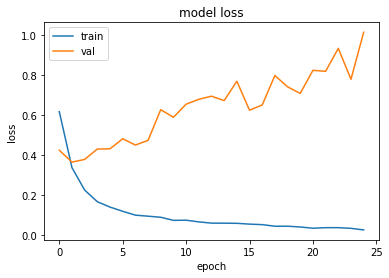

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 17s - loss: 0.5616 - acc: 0.6828 - val_loss: 0.4262 - val_acc: 0.8169
Epoch 2/25
 - 11s - loss: 0.3113 - acc: 0.8760 - val_loss: 0.3521 - val_acc: 0.8538
Epoch 3/25
 - 11s - loss: 0.2052 - acc: 0.9252 - val_loss: 0.4182 - val_acc: 0.8447
Epoch 4/25
 - 11s - loss: 0.1543 - acc: 0.9435 - val_loss: 0.4513 - val_acc: 0.8450
Epoch 5/25
 - 11s - loss: 0.1291 - acc: 0.9535 - val_loss: 0.4649 - val_acc: 0.8405
Epoch 6/25
 - 11s - loss: 0.1110 - acc: 0.9617 - val_loss: 0.4857 - val_acc: 0.8347
Epoch 7/25
 - 11s - loss: 0.1022 - acc: 0.9649 - val_loss: 0.5661 - val_acc: 0.8402
Epoch 8/25
 - 11s - loss: 0.0892 - acc: 0.9686 - val_loss: 0.6279 - val_acc: 0.8347
Epoch 9/25
 - 11s - loss: 0.0844 - acc: 0.9709 - val_loss: 0.5816 - val_acc: 0.8254
Epoch 10/25
 - 11s - loss: 0.0739 - acc: 0.9758 - val_loss: 0.6214 - val_acc: 0.8296
Epoch 11/25
 - 11s - loss: 0.0754 - acc: 0.9745 - val_loss: 0.6586 - val_acc: 0.8251
Epoch 12/25
 - 12s - loss:

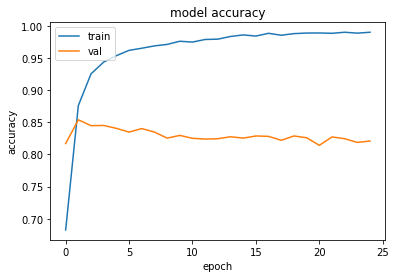

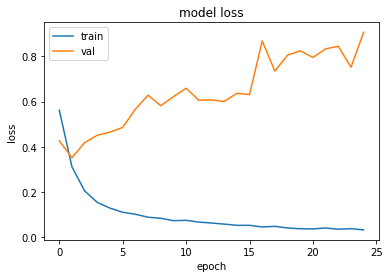

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 18s - loss: 0.5735 - acc: 0.6710 - val_loss: 0.3924 - val_acc: 0.8296
Epoch 2/25
 - 11s - loss: 0.3091 - acc: 0.8750 - val_loss: 0.3635 - val_acc: 0.8444
Epoch 3/25
 - 12s - loss: 0.2149 - acc: 0.9224 - val_loss: 0.3823 - val_acc: 0.8475
Epoch 4/25
 - 12s - loss: 0.1649 - acc: 0.9427 - val_loss: 0.4157 - val_acc: 0.8438
Epoch 5/25
 - 12s - loss: 0.1393 - acc: 0.9526 - val_loss: 0.4696 - val_acc: 0.8366
Epoch 6/25
 - 11s - loss: 0.1187 - acc: 0.9599 - val_loss: 0.5088 - val_acc: 0.8332
Epoch 7/25
 - 12s - loss: 0.1017 - acc: 0.9671 - val_loss: 0.5436 - val_acc: 0.8378
Epoch 8/25
 - 12s - loss: 0.0895 - acc: 0.9733 - val_loss: 0.4703 - val_acc: 0.8338
Epoch 9/25
 - 12s - loss: 0.0925 - acc: 0.9699 - val_loss: 0.4809 - val_acc: 0.8308
Epoch 10/25
 - 12s - loss: 0.0967 - acc: 0.9681 - val_loss: 0.5471 - val_acc: 0.8299
Epoch 11/25
 - 12s - loss: 0.0738 - acc: 0.9748 - val_loss: 0.6027 - val_acc: 0.8354
Epoch 12/25
 - 12s - loss:

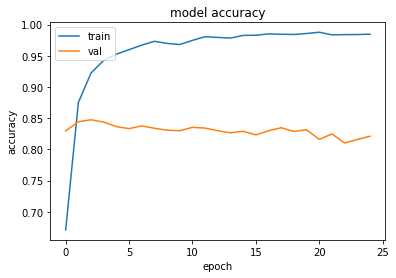

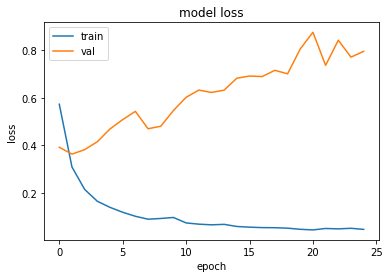

In [27]:
run_regs()

However, the above four types of regularization don't have significant effect on overfitting situation. Next, I tried to only impose regularization on the last layer, as the weight decay in the front layers are relatively small due to vanishing gradient problem.

In [0]:
def run_inconsistent_regs():
    n_layer = 3
    layer_type = GRU
    n_units = [100]*3 
    v_dropout = [0.02]*3
    v_rdropout = [0.02]*3
    regularizers = [l1_l2(0.001, 0.001), l1_l2(0., 0.001), l1_l2(0.001, 0.), l1_l2(0., 0.)]

    models = []
    histories = []

    for reg in regularizers:
        # layer 1: no regularization
        # layer 2: no regularization 
        # layer 3: l1l2(0.001, 0.001)
        kernel_reg = [l1_l2(0., 0.), l1_l2(0., 0.), reg]
        rec_reg = [l1_l2(0., 0.), l1_l2(0., 0.), reg]
        model = compile_rnn(n_layer, layer_type, n_units, v_dropout, v_rdropout, kernel_reg, rec_reg)
        hist = model.fit(X_train_pad_shrinked, y_train_shrinked, batch_size=128, epochs=25, validation_data=(X_val_pad, y_val), verbose=2)
        models.append(model)
        histories.append(hist)
    return list(zip(models, histories))

In [35]:
exp_results = run_inconsistent_regs()

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 20s - loss: 2.5658 - acc: 0.6163 - val_loss: 1.2524 - val_acc: 0.8005
Epoch 2/25
 - 12s - loss: 0.7039 - acc: 0.8572 - val_loss: 0.4479 - val_acc: 0.8526
Epoch 3/25
 - 11s - loss: 0.2825 - acc: 0.9169 - val_loss: 0.3837 - val_acc: 0.8581
Epoch 4/25
 - 11s - loss: 0.2063 - acc: 0.9411 - val_loss: 0.4231 - val_acc: 0.8459
Epoch 5/25
 - 11s - loss: 0.1764 - acc: 0.9535 - val_loss: 0.4980 - val_acc: 0.8423
Epoch 6/25
 - 12s - loss: 0.1706 - acc: 0.9541 - val_loss: 0.4738 - val_acc: 0.8423
Epoch 7/25
 - 12s - loss: 0.1454 - acc: 0.9646 - val_loss: 0.5487 - val_acc: 0.8475
Epoch 8/25
 - 12s - loss: 0.1249 - acc: 0.9707 - val_loss: 0.5368 - val_acc: 0.8381
Epoch 9/25
 - 12s - loss: 0.1235 - acc: 0.9711 - val_loss: 0.5017 - val_acc: 0.8360
Epoch 10/25
 - 12s - loss: 0.1135 - acc: 0.9744 - val_loss: 0.5603 - val_acc: 0.8369
Epoch 11/25
 - 11s - loss: 0.1044 - acc: 0.9769 - val_loss: 0.6436 - val_acc: 0.8350
Epoch 12/25
 - 12s - loss:

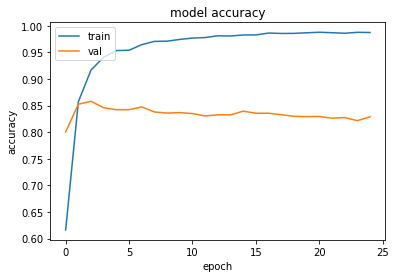

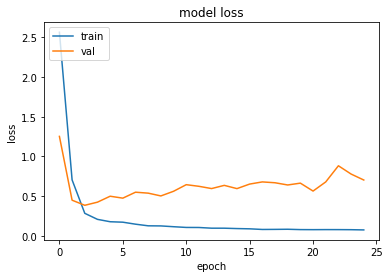

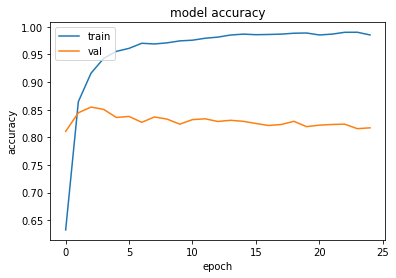

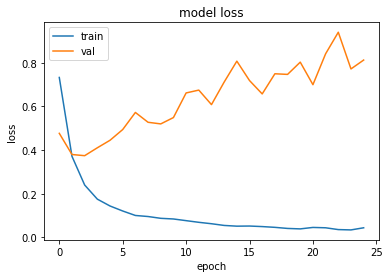

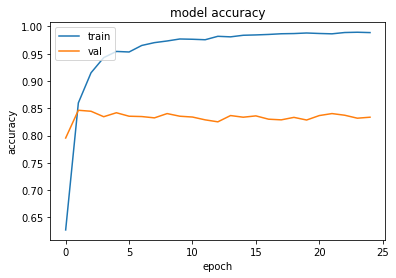

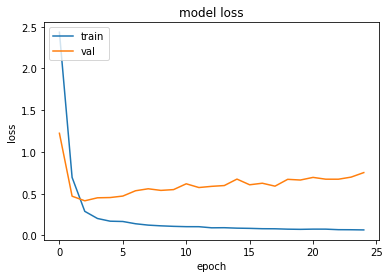

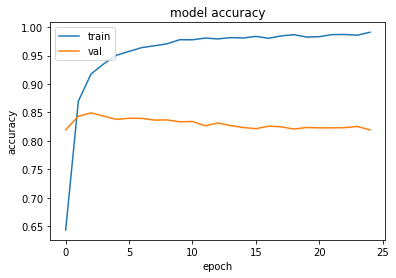

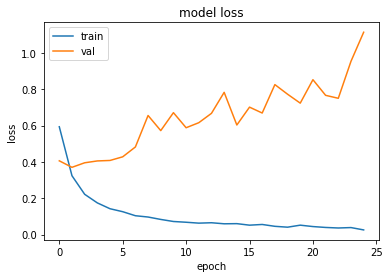

In [38]:
plot_history(exp_results[0][1])
plot_history(exp_results[1][1])
plot_history(exp_results[2][1])
plot_history(exp_results[3][1])

From the above experiments, adding l1_l2(0.001, 0.001) to the kernel and recurrent regularizer of the last GRU layer will alleviate overfitting to the best extent among these four regularizations. 

Lastly, I tried to change the regularization factor to 0.01 and see whether the effect is better.

In [39]:
reg = [l1_l2(0., 0.), l1_l2(0., 0.), l1_l2(0.01, 0.01)]
model = compile_rnn(3, GRU, [100]*3, [0.02]*3, [0.02]*3, reg, reg)
hist = model.fit(X_train_pad_shrinked, y_train_shrinked, batch_size=128, epochs=25, validation_data=(X_val_pad, y_val), verbose=2)

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 23s - loss: 20.2236 - acc: 0.5892 - val_loss: 8.3132 - val_acc: 0.8069
Epoch 2/25
 - 12s - loss: 3.4645 - acc: 0.8531 - val_loss: 0.8973 - val_acc: 0.8499
Epoch 3/25
 - 11s - loss: 0.5341 - acc: 0.9144 - val_loss: 0.5423 - val_acc: 0.8574
Epoch 4/25
 - 11s - loss: 0.3746 - acc: 0.9333 - val_loss: 0.5812 - val_acc: 0.8541
Epoch 5/25
 - 11s - loss: 0.3266 - acc: 0.9487 - val_loss: 0.5930 - val_acc: 0.8517
Epoch 6/25
 - 11s - loss: 0.3027 - acc: 0.9579 - val_loss: 0.5543 - val_acc: 0.8447
Epoch 7/25
 - 11s - loss: 0.2899 - acc: 0.9591 - val_loss: 0.5872 - val_acc: 0.8456
Epoch 8/25
 - 11s - loss: 0.2714 - acc: 0.9654 - val_loss: 0.5844 - val_acc: 0.8462
Epoch 9/25
 - 11s - loss: 0.2593 - acc: 0.9687 - val_loss: 0.6479 - val_acc: 0.8341
Epoch 10/25
 - 11s - loss: 0.2670 - acc: 0.9630 - val_loss: 0.5544 - val_acc: 0.8387
Epoch 11/25
 - 11s - loss: 0.2487 - acc: 0.9707 - val_loss: 0.5973 - val_acc: 0.8438
Epoch 12/25
 - 11s - loss

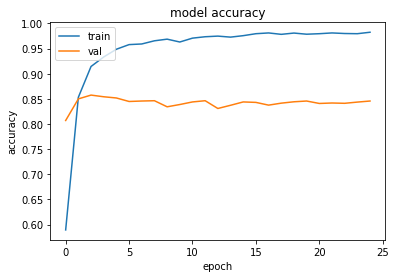

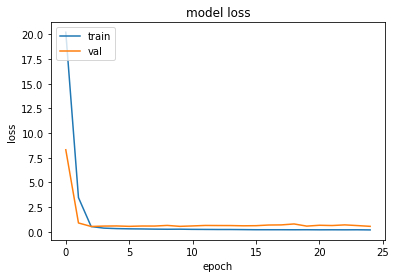

In [40]:
plot_history(hist)

A larger factor does show stronger effect on preventing overfitting. 0.01 is a frequently adopted value and people seldomly go beyond that, so I chose not to try a larger value. 
In conclusion, a l1_l2(0.01, 0.01) regularization on the recurrent process and kernel of the last layer. 

#### 2. Number of epoches

In [0]:
def run_epoches():
    n_layer = 3
    layer_type = GRU
    n_units = [100]*3 
    v_dropout = [0.02]*3
    v_rdropout = [0.02]*3
    reg = [l1_l2(0., 0.), l1_l2(0., 0.), l1_l2(0.01, 0.01)]
    model = compile_rnn(n_layer, layer_type, n_units, v_dropout, v_rdropout, reg, reg)

    models = []
    histories = []
    epoches = [25, 50]

    for epoch in epoches:
        hist = model.fit(X_train_pad_shrinked, y_train_shrinked, batch_size=128, epochs=epoch, validation_data=(X_val_pad, y_val), verbose=2)
        models.append(model)
        histories.append(hist)
    return list(zip(models, histories))

In [44]:
epoches_exp_results = run_epoches()

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 24s - loss: 19.8960 - acc: 0.6334 - val_loss: 8.2054 - val_acc: 0.8127
Epoch 2/25
 - 11s - loss: 3.4298 - acc: 0.8654 - val_loss: 0.9231 - val_acc: 0.8462
Epoch 3/25
 - 11s - loss: 0.5391 - acc: 0.9161 - val_loss: 0.5290 - val_acc: 0.8517
Epoch 4/25
 - 11s - loss: 0.3707 - acc: 0.9354 - val_loss: 0.5283 - val_acc: 0.8411
Epoch 5/25
 - 11s - loss: 0.3258 - acc: 0.9519 - val_loss: 0.5757 - val_acc: 0.8553
Epoch 6/25
 - 11s - loss: 0.3038 - acc: 0.9540 - val_loss: 0.5386 - val_acc: 0.8529
Epoch 7/25
 - 11s - loss: 0.2842 - acc: 0.9625 - val_loss: 0.5389 - val_acc: 0.8438
Epoch 8/25
 - 11s - loss: 0.2658 - acc: 0.9668 - val_loss: 0.5982 - val_acc: 0.8462
Epoch 9/25
 - 11s - loss: 0.2558 - acc: 0.9694 - val_loss: 0.5438 - val_acc: 0.8532
Epoch 10/25
 - 11s - loss: 0.2573 - acc: 0.9686 - val_loss: 0.6814 - val_acc: 0.8517
Epoch 11/25
 - 11s - loss: 0.2453 - acc: 0.9726 - val_loss: 0.6041 - val_acc: 0.8420
Epoch 12/25
 - 11s - loss

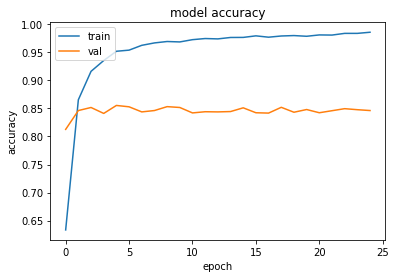

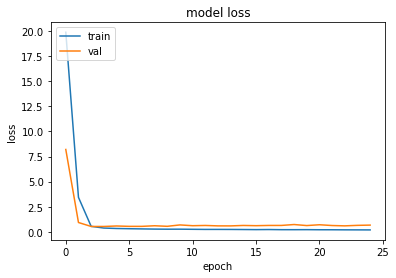

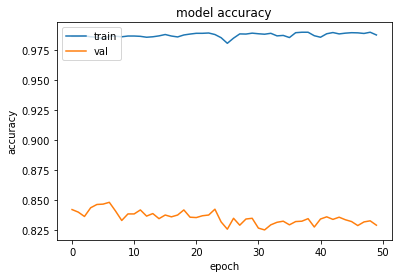

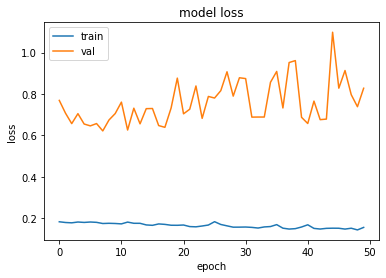

In [46]:
plot_history(epoches_exp_results[0][1])
plot_history(epoches_exp_results[1][1])

From the above experiments, 25 epoches seem to fit our case better than 50 epoches.

#### 3. Number of layers

In [0]:
def run_layers():
    models = []
    histories = []
    layer_type = GRU
    n_layer = [3, 5]
    for layer in n_layer:
        n_units = [100]*layer
        v_dropout = [0.02]*layer
        v_rdropout = [0.02]*layer
        reg = [l1_l2(0., 0.)] * (layer-1) + [l1_l2(0.01, 0.01)]
        model = compile_rnn(layer, layer_type, n_units, v_dropout, v_rdropout, reg, reg)

        hist = model.fit(X_train_pad_shrinked, y_train_shrinked, batch_size=128, epochs=25, validation_data=(X_val_pad, y_val), verbose=2)
        models.append(model)
        histories.append(hist)
    return list(zip(models, histories))

In [52]:
layers_exp_results = run_layers()

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 25s - loss: 19.9400 - acc: 0.6170 - val_loss: 8.2038 - val_acc: 0.8136
Epoch 2/25
 - 11s - loss: 3.4170 - acc: 0.8586 - val_loss: 0.8976 - val_acc: 0.8472
Epoch 3/25
 - 11s - loss: 0.5312 - acc: 0.9156 - val_loss: 0.5385 - val_acc: 0.8541
Epoch 4/25
 - 11s - loss: 0.3624 - acc: 0.9405 - val_loss: 0.5426 - val_acc: 0.8459
Epoch 5/25
 - 11s - loss: 0.3306 - acc: 0.9464 - val_loss: 0.5257 - val_acc: 0.8514
Epoch 6/25
 - 12s - loss: 0.3067 - acc: 0.9532 - val_loss: 0.5443 - val_acc: 0.8499
Epoch 7/25
 - 11s - loss: 0.2850 - acc: 0.9607 - val_loss: 0.5604 - val_acc: 0.8499
Epoch 8/25
 - 11s - loss: 0.2734 - acc: 0.9647 - val_loss: 0.6048 - val_acc: 0.8444
Epoch 9/25
 - 11s - loss: 0.2643 - acc: 0.9648 - val_loss: 0.6217 - val_acc: 0.8469
Epoch 10/25
 - 11s - loss: 0.2540 - acc: 0.9695 - val_loss: 0.5509 - val_acc: 0.8402
Epoch 11/25
 - 11s - loss: 0.2531 - acc: 0.9671 - val_loss: 0.6500 - val_acc: 0.8456
Epoch 12/25
 - 12s - loss

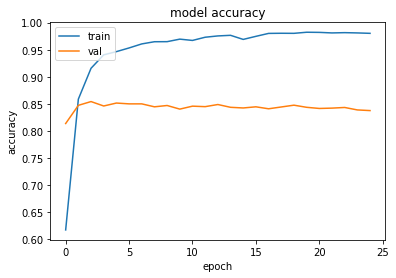

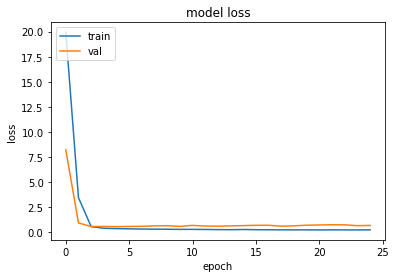

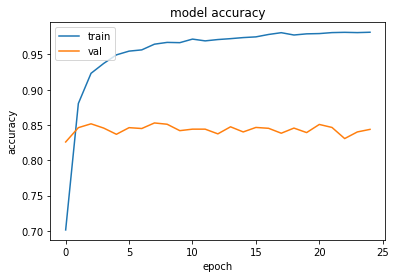

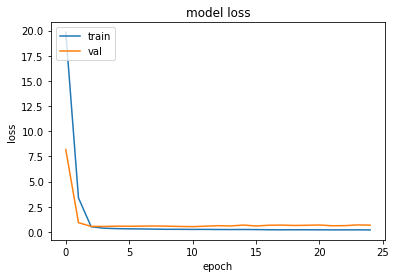

In [55]:
# 3 GRU layers
plot_history(layers_exp_results[0][1])

# 5 GRU layers
plot_history(layers_exp_results[1][1])


Finally, we chosen 3 number of layers.

#### 4. bidirectional layer

Bidirectional layers are quite frequently used in NLP tasks now because of its ability of capturing semantic information both in the past and in the future. Thus, I tested it and wanted to see whether it could out perform the normal GRU layer.

In [0]:
def compile_bi_rnn(n_layer, layer_type, n_units, v_dropout, v_rdropout, kernel_reg, rec_reg): 
    """
    Assume the length of the parameters is equal to n_layer
    """
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
    for i in range(n_layer):
    if i == n_layer-1: 
        model.add(Bidirectional(layer_type(units=n_units[i], 
                          dropout=v_dropout[i], 
                          recurrent_dropout=v_rdropout[i],
                          kernel_regularizer=kernel_reg[i], 
                          recurrent_regularizer=rec_reg[i])))
    else: 
        model.add(Bidirectional(layer_type(units=n_units[i], 
                           dropout=v_dropout[i], 
                           recurrent_dropout=v_rdropout[i],
                           return_sequences=True,
                           kernel_regularizer=kernel_reg[i], 
                           recurrent_regularizer=rec_reg[i])))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
def run_bidirectional():
    models = []
    histories = []

    layer_type = GRU
    n_layer = 3
    n_units = [100]*n_layer
    v_dropout = [0.02]*n_layer
    v_rdropout = [0.02]*n_layer
    reg = [l1_l2(0., 0.)] * 2 + [l1_l2(0.01, 0.01)]
    
    # bidirectional model
    model_bidirectional = compile_bi_rnn(n_layer, layer_type, n_units, v_dropout, v_rdropout, reg, reg)
    hist_bidirectional = model_bidirectional.fit(
        X_train_pad_shrinked, 
        y_train_shrinked, 
        batch_size=128, 
        epochs=25, 
        validation_data=(X_val_pad, y_val), verbose=2)
    models.append(model_bidirectional)
    histories.append(hist_bidirectional)

    # normal deep gru network
    model_normal = compile_rnn(n_layer, layer_type, n_units, v_dropout, v_rdropout, reg, reg)
    hist_normal = model_normal.fit(
        X_train_pad_shrinked, 
        y_train_shrinked, 
        batch_size=128, 
        epochs=25, 
        validation_data=(X_val_pad, y_val), verbose=2)
    models.append(model_normal)
    histories.append(hist_normal)

    return list(zip(models, histories))

In [65]:
bidirectional_exp_results = run_bidirectional()

Train on 7929 samples, validate on 3304 samples
Epoch 1/25
 - 46s - loss: 54.5876 - acc: 0.7282 - val_loss: 19.9057 - val_acc: 0.8278
Epoch 2/25
 - 28s - loss: 7.0312 - acc: 0.8780 - val_loss: 1.4166 - val_acc: 0.8496
Epoch 3/25
 - 27s - loss: 0.7936 - acc: 0.9199 - val_loss: 0.7277 - val_acc: 0.8571
Epoch 4/25
 - 27s - loss: 0.5261 - acc: 0.9385 - val_loss: 0.6857 - val_acc: 0.8496
Epoch 5/25
 - 27s - loss: 0.4798 - acc: 0.9508 - val_loss: 0.6704 - val_acc: 0.8475
Epoch 6/25
 - 28s - loss: 0.4476 - acc: 0.9595 - val_loss: 0.6852 - val_acc: 0.8475
Epoch 7/25
 - 27s - loss: 0.4262 - acc: 0.9662 - val_loss: 0.7488 - val_acc: 0.8453
Epoch 8/25
 - 27s - loss: 0.4152 - acc: 0.9683 - val_loss: 0.7036 - val_acc: 0.8417
Epoch 9/25
 - 27s - loss: 0.4045 - acc: 0.9702 - val_loss: 0.7139 - val_acc: 0.8493
Epoch 10/25
 - 27s - loss: 0.3923 - acc: 0.9735 - val_loss: 0.7535 - val_acc: 0.8453
Epoch 11/25
 - 27s - loss: 0.3730 - acc: 0.9794 - val_loss: 0.8356 - val_acc: 0.8444
Epoch 12/25
 - 27s - los

bi-directional layers


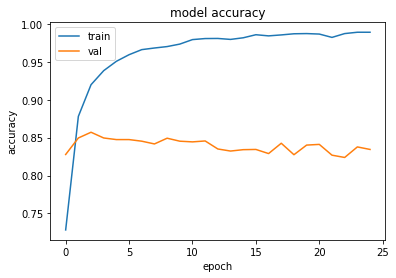

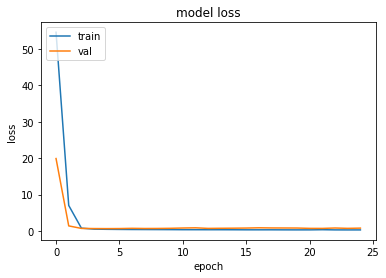

normal layers


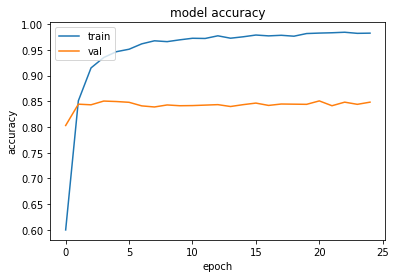

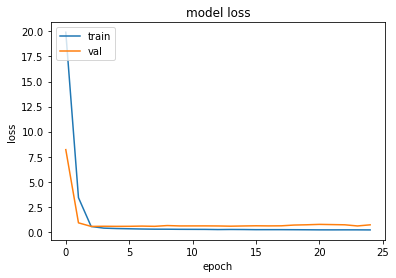

In [70]:
print("bi-directional layers")
plot_history(bidirectional_exp_results[0][1])

print("normal layers")
plot_history(bidirectional_exp_results[1][1])

The validation accuracy of the network just using normal GRU layers is more stable. In contrast, the validation accuracy of the network using bidirectional layers shows a decreasing trend. On the other hand, the training/validation loss and training accuracy for these two models are almost the same. Considering bidirectional layers consumes more time, I chose to use normal GRU in this case. 

## Evaluation metrics

In [0]:
model_tuned = Sequential()
model_tuned.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model_tuned.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_tuned.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_tuned.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, 
                               kernel_regularizer=l1_l2(0.01, 0.01), recurrent_regularizer=l1_l2(0.01, 0.01)))
model_tuned.add(Dense(1, activation='sigmoid'))

model_tuned.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
model_tuned.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_val_pad, y_val), verbose=2)

Train on 13216 samples, validate on 3304 samples
Epoch 1/25
 - 37s - loss: 13.9924 - acc: 0.6391 - val_loss: 1.8200 - val_acc: 0.8290
Epoch 2/25
 - 18s - loss: 0.7304 - acc: 0.8561 - val_loss: 0.5165 - val_acc: 0.8568
Epoch 3/25
 - 19s - loss: 0.4270 - acc: 0.8983 - val_loss: 0.4798 - val_acc: 0.8674
Epoch 4/25
 - 19s - loss: 0.3756 - acc: 0.9184 - val_loss: 0.5042 - val_acc: 0.8590
Epoch 5/25
 - 18s - loss: 0.3413 - acc: 0.9377 - val_loss: 0.5014 - val_acc: 0.8602
Epoch 6/25
 - 19s - loss: 0.3120 - acc: 0.9450 - val_loss: 0.4705 - val_acc: 0.8689
Epoch 7/25
 - 19s - loss: 0.2953 - acc: 0.9485 - val_loss: 0.4845 - val_acc: 0.8717
Epoch 8/25
 - 19s - loss: 0.2751 - acc: 0.9563 - val_loss: 0.4709 - val_acc: 0.8647
Epoch 9/25
 - 19s - loss: 0.2669 - acc: 0.9613 - val_loss: 0.5188 - val_acc: 0.8659
Epoch 10/25
 - 19s - loss: 0.2507 - acc: 0.9639 - val_loss: 0.5244 - val_acc: 0.8650
Epoch 11/25
 - 19s - loss: 0.2403 - acc: 0.9667 - val_loss: 0.5120 - val_acc: 0.8650
Epoch 12/25
 - 18s - los

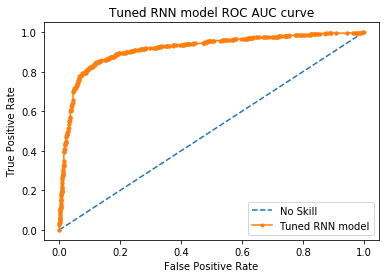

AUC score = 0.916


In [71]:
y_pred_tuned = model_tuned.predict(X_test_pad)
auc_roc_curve(y_test, y_pred_tuned, "Tuned RNN model")

[[832 101]
 [157 746]]
Accuracy: 0.8594771241830066
True Positive Rate: 0.8412537917087968
precision: 0.8917470525187567


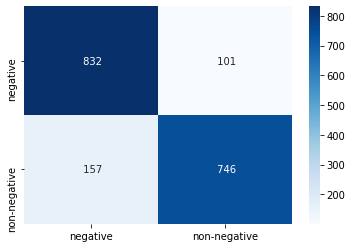

In [72]:
show_confusion_matrix(y_test, y_pred_tuned)

The tuned model beats the base model in both the accuracy and recall. The recall and precisio now look normal and model seems not to be tilted anymore.

## Your observation and comments

1. There are emojis in the tweets data set. Some package could retain the emoticons, such as the nlp() of Spacy, while the simple_preprocess method in gensim will remove them. 
2. Naive bayse method may also provide good model, while constructing a feature  map of 10k x 10k is very RAM- and time- consuming. 
3. Bidirectional RNN layer is able to not only capture the semantic information in the past, but also the information in the future. However, the training speed is slower than the normal GRU layer. It's performance on this sementic classification task is also not better than normal GRU.

# Using pre-trained model (stretch goal)

## Explain the logic behind selecting pre-trained model (for word embedding)

1. Using pre-trained word embedding saved the time in training the embedding layer.
2. The loss curve might converge faster since there are less parameters to train.
2. Given this dataset's size is limited, the semantic information of words might not be captured properly. Some relationships among words might be inaccurate such that two words with diverse meaning might probably be trained in close distance. 


## Build the model and train on the data set

In [55]:
# load the pre-trained word-embedding: 
# https://nlp.stanford.edu/projects/glove/

glove_model = KeyedVectors.load_word2vec_format('glove.6B.100d.bin', binary=True)

In [78]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
word_in_glove_count = 0

for word, i in word_index.items():
    if i > num_words: 
        continue
    elif word in glove_model.vocab: 
        embedding_matrix[i] = glove_model.get_vector(word)
        word_in_glove_count += 1

In [64]:
model_pre = Sequential()
model_pre.add(Embedding(num_words, EMBEDDING_DIM, 
                       embeddings_initializer=Constant(embedding_matrix),
                       input_length=max_length, 
                       trainable=False))
model_pre.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_pre.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_pre.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, 
                               kernel_regularizer=l1_l2(0.01, 0.01), recurrent_regularizer=l1_l2(0.01, 0.01)))
model_pre.add(Dense(1, activation='sigmoid'))

model_pre.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
history_pre = model_pre.fit(X_train_pad, y_train, batch_size=128, epochs=50, validation_data=(X_val_pad, y_val), verbose=2)

Train on 13216 samples, validate on 3304 samples
Epoch 1/50
 - 33s - loss: 13.8170 - accuracy: 0.7068 - val_loss: 2.0627 - val_accuracy: 0.6220
Epoch 2/50
 - 27s - loss: 0.8288 - accuracy: 0.7648 - val_loss: 0.7528 - val_accuracy: 0.6768
Epoch 3/50
 - 28s - loss: 0.5881 - accuracy: 0.7794 - val_loss: 0.7218 - val_accuracy: 0.7391
Epoch 4/50
 - 29s - loss: 0.5703 - accuracy: 0.7893 - val_loss: 0.7209 - val_accuracy: 0.7340
Epoch 5/50
 - 29s - loss: 0.5405 - accuracy: 0.8043 - val_loss: 0.7162 - val_accuracy: 0.7533
Epoch 6/50
 - 27s - loss: 0.5249 - accuracy: 0.8071 - val_loss: 0.6882 - val_accuracy: 0.7778
Epoch 7/50
 - 30s - loss: 0.5115 - accuracy: 0.8174 - val_loss: 0.6955 - val_accuracy: 0.7760
Epoch 8/50
 - 31s - loss: 0.5003 - accuracy: 0.8236 - val_loss: 0.7178 - val_accuracy: 0.7748
Epoch 9/50
 - 31s - loss: 0.4865 - accuracy: 0.8282 - val_loss: 0.6908 - val_accuracy: 0.7476
Epoch 10/50
 - 31s - loss: 0.4744 - accuracy: 0.8331 - val_loss: 0.7115 - val_accuracy: 0.7473
Epoch 11/

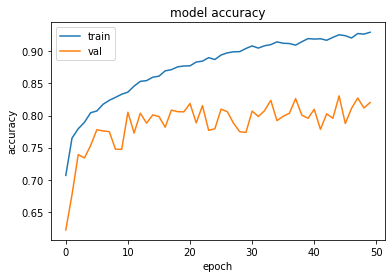

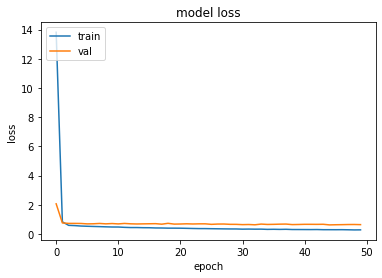

In [66]:
plot_history(history_pre)

Superisingly, it converges very slow compared with the basic model. Another interesting fact is that out of the 11216 unique words of the tweets data, only 6880 of them are present in the Glove pre-trained word embedding. That means there are 4336 empty word embeddings in the embedding matrix, which could be a reason for such as slow convergence.

In [80]:
print("total unique words in tweets: {}".format(num_words))
print("words present in glove word embedding: {}".format(word_in_glove_count))
print("words absent in glove word embedding: {}".format(num_words - word_in_glove_count))

total unique words in tweets: 11216
words present in glove word embedding: 6880
words absent in glove word embedding: 4336


## Evaluation metrics

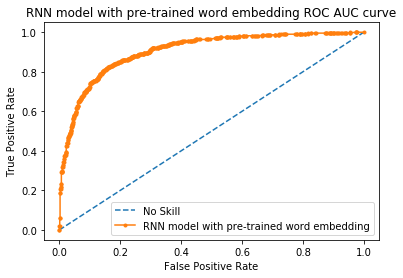

AUC score = 0.905


In [68]:
y_pred_pre = model_pre.predict(X_test_pad)
auc_roc_curve(y_test, y_pred_pre, "RNN model with pre-trained word embedding")

[[851  82]
 [269 634]]
Accuracy: 0.8088235294117647
True Positive Rate: 0.7598214285714285
precision: 0.9121114683815649


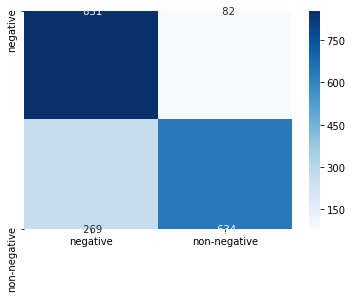

In [69]:
show_confusion_matrix(y_test, y_pred_pre)

Similar with the un-tuned base model, the recall rate is also relatively low.

## Compare with your previous trained model

RNN model with pre-trained word embedding

[[851  82]
 [269 634]]
Accuracy: 0.8088235294117647
True Positive Rate: 0.7598214285714285
precision: 0.9121114683815649


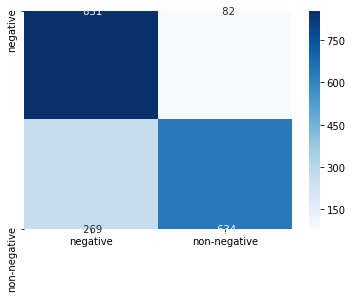

In [81]:
show_confusion_matrix(y_test, y_pred_pre)

RNN model with trained word embedding

[[832 101]
 [157 746]]
Accuracy: 0.8594771241830066
True Positive Rate: 0.8412537917087968
precision: 0.8917470525187567


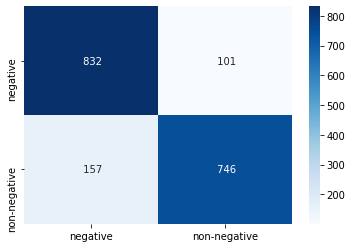

In [72]:
show_confusion_matrix(y_test, y_pred_tuned)

It is clear that the model with pre-trained word embedding is not as good as tuned base model in both accuracy and recall rate. It's power of identifying negative tweets is not as strong as the tuned base model. On the other hand, the speed of using pre-trained word embedding doesn't improve significantly. It might be because the pre-trained word embedding doesn't cover most of the words in the local data set. 

Of course, it can be also because the word pre-processing of the tweets data set is not sufficient such that rare words or typos are not removed from the data set. 

# Some thoughts on the model

## How do you divide the dataset for training/testing and validation?

Divide the data set to training and testing set first. In this case, train: test = 0.9.  
Secondly, divide the train data set to real train data and validation set. In this case, train: validation = 0.8

## Have you any kind of regularisation, justify your logic.

Applied elastic-net regularization on the third GRU layer of the RNN model. Im the tunning process, applying the regularization on all the three layers with a factor of 0.001 couldn't really affect the validation loss, while a factor of 0.01 will freeze the validation accuracy to around 0.6. Therefore, I tried to impose regularization only on the last layer with a factor of 0.001. The validation loss started to drop as the epoches increase. When the factor changes to 0.01, the regularization becomes stronger and the validation loss almost shows the same trend as the training loss. Validation accuracy also slightly increases with the increasing epoches. 

In addition, a recurrent dropout and kernel dropout with probability of 0.2 are imposed on every layer. Although they may add extra noise to the training process, they are quite frequently used in a deep learning architecture.

## What are the further improvements you can make to the model, if you are given more time?

1. Apply other supervised learning, such as naive bayse and SVM. Emsemble the models together, such as using voting or stacking, would probably achieve better performance. 
2. Another possible way: Build multinominal classification model and then merge the predicted results into 2 classes.
3. look into more details of data preprocessing and try to identify problems why there are so many words not covered in glove word embedding.

## Final words, about the problem statement.

Pre-trained word embedding should be faster and provide better performance compared with using locally trained word embeddings. However, the advantage only comes when the local data set is too large such that training word embedding takes too much time. On the other hand, if the local data sets contains a large amount of data not covered by the pre-trained data set, just like this case, the formed embedding matrix could be very sparse and some key feature to identify the sentiment will be lost. 